### The Linear Regression File 

# number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
#          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7

In [26]:
### QUESTIONS FOR THE TA'S ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [27]:
arr = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
X = np.array([arr + (arr[-1]*i) for i in range(len(arr) - 2)])

def generate_y(array, horizon):
    close = array[:,4] ### 1)
    return close[horizon:] ### 2)


horizon = 7
G = X[:-horizon]
y = generate_y(X,horizon)

X_shape = X.shape
y_shape = y.shape

print(G.shape)
print(y_shape)

(3, 12)
(3,)


In [28]:
import preprocess
files = preprocess.potential_files[:5]

preprocess_class_instantiation = preprocess.preprocess(files, 7)

datasets = preprocess_class_instantiation.generate_data()

file_for_given_row = {}
for index, crypto_name in enumerate(files):
    file_for_given_row[crypto_name] = index
    # if crypto_name == '1INCH.csv':
    # print(f'index : {index} -- crypto_name : {crypto_name}')

# for key, val in file_for_given_row.items():
#     print(key, val)

# print(file_for_given_row['1INCH.csv'])

for f in files:
    print(f"https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select={f}")

# print(datasets)

processing files
Loading 1INCH.csv...
Loading AAVE.csv...
Loading ADA.csv...
Loading ALGO.csv...
Loading AMP.csv...
The columns are: (number of days since start,open,high,low,close,sma(10 days),golden cross, death cross)
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=1INCH.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=AAVE.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=ADA.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=ALGO.csv
https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select=AMP.csv


In [29]:
##### NESTED LIST RETRIEVAL OF X FOR GIVEN CURRENCY ##################################################################################
# filename = '1INCH.csv'

def get_X_or_y_for_given_currency(currency, x_or_y):
    processed_file_dict = {}

    if (x_or_y == 'X') or (x_or_y == 'x'):
        x_or_y = 0
    elif (x_or_y == 'Y') or (x_or_y == 'y'):
        x_or_y = 1
    else:
        print(f'x_or_y needs to be x or y')
    
    row = file_for_given_row[currency]
    
    for csv_name, row in file_for_given_row.items():
        if currency == csv_name:
            processed_file_dict[csv_name] = datasets[row][x_or_y]
            return processed_file_dict[csv_name]
    
# get_X_or_y_for_given_currency(filename, 'X')
# get_X_or_y_for_given_currency(filename, 'y')

In [30]:
currency_we_want_to_look_at = '1INCH.csv'
# currency_we_want_to_look_at = 'AAVE.csv'
# currency_we_want_to_look_at = 'ADA.csv'
# currency_we_want_to_look_at = 'ALGO.csv'
# currency_we_want_to_look_at = 'AMP.csv'

X = get_X_or_y_for_given_currency(currency_we_want_to_look_at, 'X')
y = get_X_or_y_for_given_currency(currency_we_want_to_look_at, 'y')

print(X.shape)
print(y.shape)

# print("first row of X:", X[0])
# print("first 10 closes from X[:,4]:", X[:10, 4])
# print("first 10 y values:", y[:10])


(1535, 8)
(1535,)


# Multivariable Linear Regression Section
### 1) find the most sig weihts (features) and dicuss what that means
### 2) get the LOBF to be fitted to the data trajectory
### 3) discuss various errors measured against the data and what that tells us about the real values vs our pred values ()

### get a function that fits the line better 

##### A model that is overfitting has the following characteristics:

###### - It matches the training set too closely.
###### - It does well on the training data, but doesn't *generalize* to new data.  In other words, it performs poorly on independent test data.
###### - It learns from the noise in the data, rather than the signal.

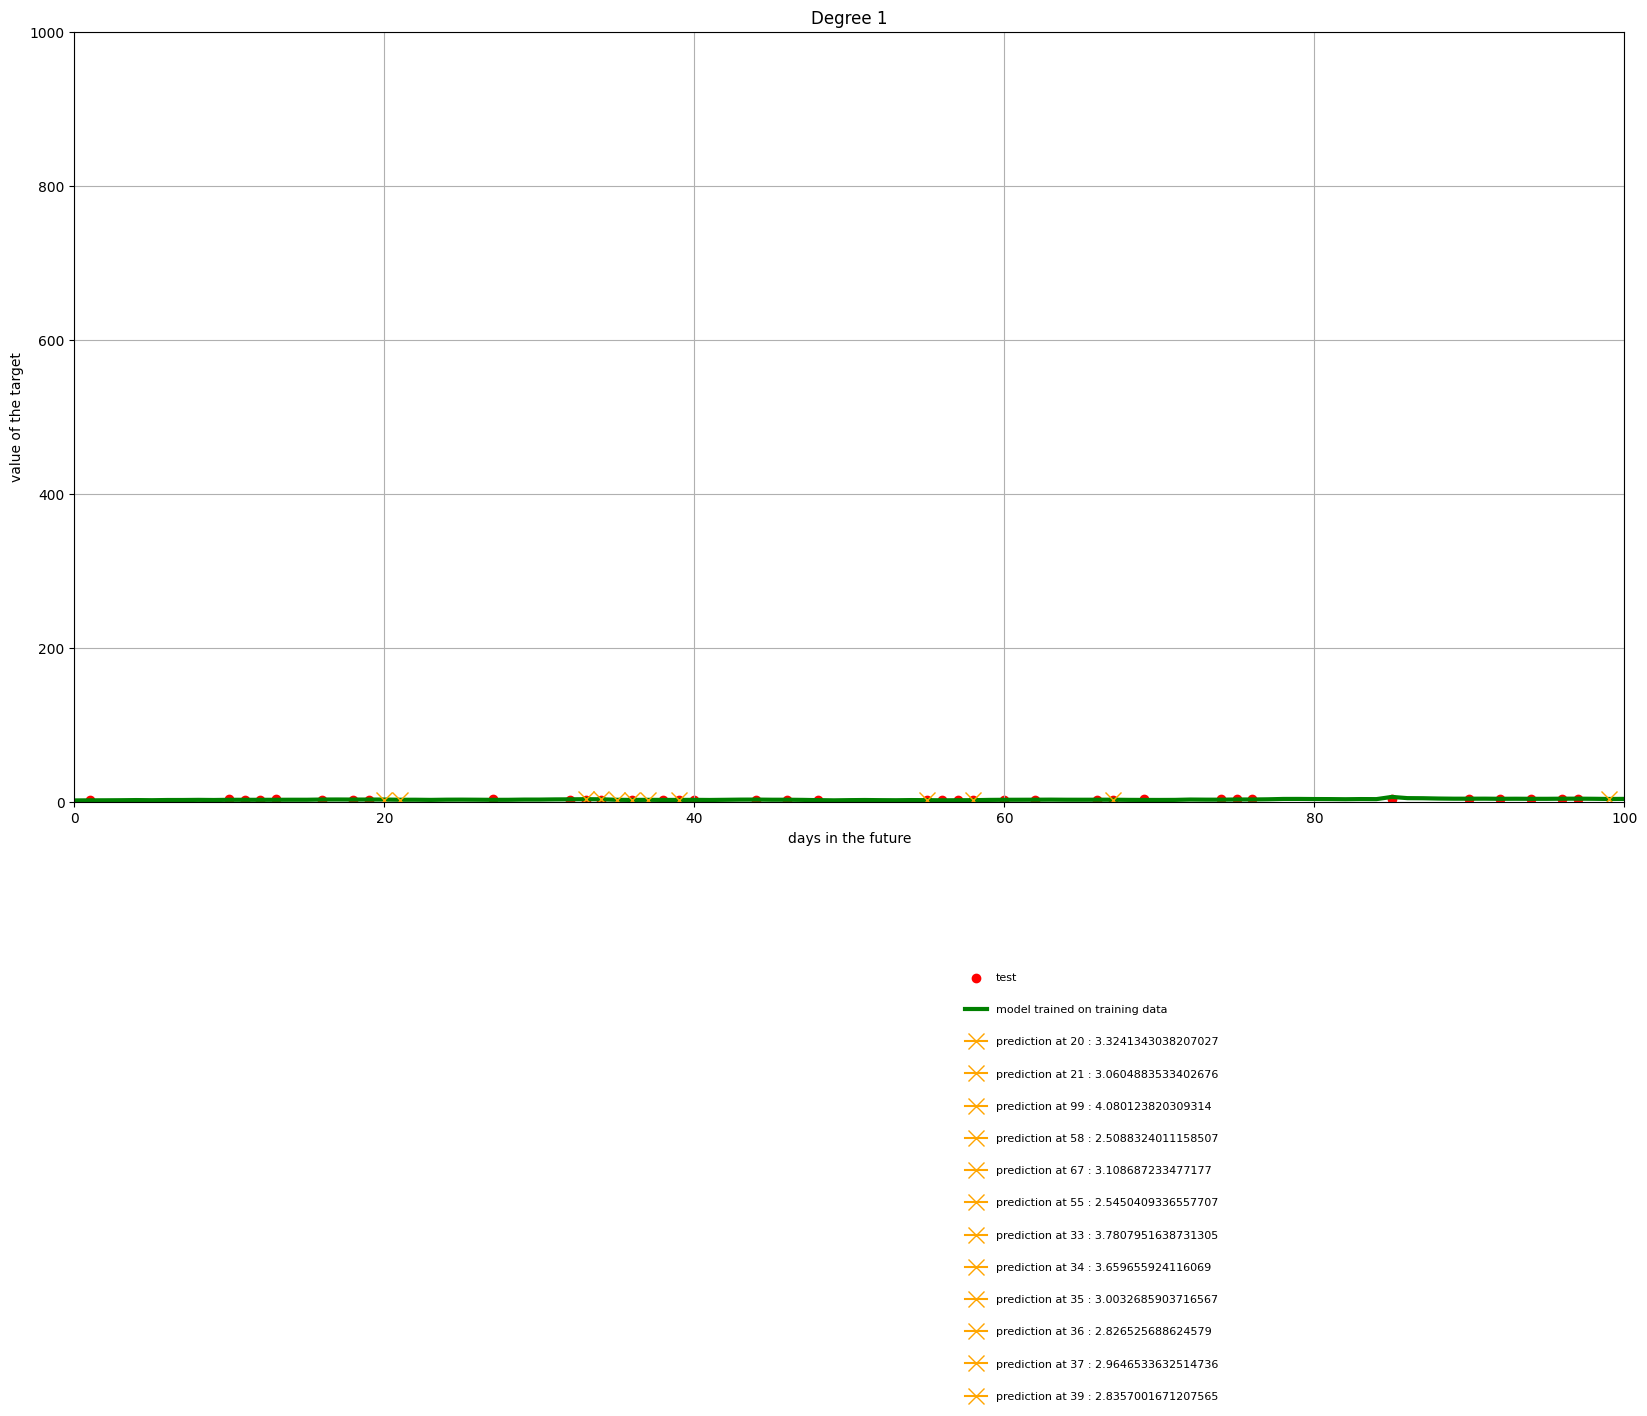

In [ ]:
# # ## number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
# # ##          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X0 = X[:, [0]]

def get_prediction_at_given_x(pipeln, feature_indecies, prediction_points, ax):
    preds = []
    for h in prediction_points:
        x_row = X[h, feature_indecies].reshape(1, -1)
        y_pred_at_this_point = pipeln.predict(x_row)[0]
        preds.append(y_pred_at_this_point)
        # print(y_pred_at_this_point)
        # print(X[h,0])
        # print(h)
        ax.plot(h, y_pred_at_this_point, marker='x', color='orange', label=f'prediction at {h} : {y_pred_at_this_point}', markersize=12)
    return preds

def predictionVals_Plot_DictOfErrors(prediction_points):
    train_and_test_errors_at_given_degree = {}
    polynomial_degrees = [1,2,3,4,5,6,7,8]
    feature_indecies = [0,1,2,3,4,5,6,7]
    plt.figure(figsize=(20,10))
    
    alphas_to_test = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
    for i in range(len(polynomial_degrees)):
        
        ### NOTE: make the line eq a mutlti-var lin eq
        polynomial_features_train = PolynomialFeatures(degree=polynomial_degrees[i], include_bias=False)
        
        ### NOTE: apply lin reg to the new mutlti-var lin eq
        linear_regression_model_train = RidgeCV(alphas=alphas_to_test)# ridge adds l2 to regression to shrink the coefficients of the loss funciton to prevent overfitting
        
        ### NOTE: instantiate the pipline
        pipeline_on_training_data = Pipeline([("polynomial_features", polynomial_features_train), ("linear_regression", linear_regression_model_train)])
        
        ### NOTE: apply the pipline
        
        ##spilt
        #                                                                                                                       
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X[:, feature_indecies], y, test_size=0.3, random_state=67, shuffle=True)

        ##fit 
        pipeline_on_training_data.fit(X_train2, y_train2)
        
        ##predict on train and test
        y_pred_train2 = pipeline_on_training_data.predict(X_train2)
        y_pred_test2 = pipeline_on_training_data.predict(X_test2)
        
        train_MAE2 = mean_absolute_error(y_train2, y_pred_train2)
        test_MAE2 = mean_absolute_error(y_test2, y_pred_test2)
        
        train_MSE2 = mean_squared_error(y_train2, y_pred_train2)
        test_MSE2 = mean_squared_error(y_test2, y_pred_test2)

        train_RMSE2 = np.sqrt(train_MSE2)
        test_RMSE2 = np.sqrt(test_MSE2)
        
        naive_MAE2 = mean_absolute_error(y_test2, np.full(y_test2.shape, np.mean(y_train2)))
        
        if polynomial_degrees[i] == 1:
            ax = plt.subplot(1,1,1)
            plt.xlabel('x')
            plt.ylabel('y')
            ax.scatter(X_test2[:,0], y_test2, color="red", label='test')
            ax.set_xlim(0,100)
            # ax.set_ylim(0,1000)
            
            # LOBF_X = pipeline1.predict(X[:, feature_indecies])
            LOBF_train_set = pipeline_on_training_data.predict(X[:, feature_indecies])
            
            # ax.plot(X0, LOBF_X, label="model trained on all data", color="purple", linewidth=2) data leakage 
            ax.plot(X0, LOBF_train_set, label="model trained on training data", color="green", linewidth=3)
            
            prediction_vals = get_prediction_at_given_x(pipeline_on_training_data, feature_indecies, prediction_points, ax)
            
            ax.set_xlabel(f'days in the future')
            
            ax.set_ylabel('value of the target')
            ax.legend(loc='center left', bbox_to_anchor=(0.5, -0.5), ncol=1, fontsize=8, frameon=False, borderaxespad=10, labelspacing=2)
            plt.title(f"Degree {polynomial_degrees[i]}")
            ax.grid() 
            
            best_fit_plot = plt.gcf()
        
        train_and_test_errors_at_given_degree[i] = {
            
            'train' : {
                'MAE' : train_MAE2,
                'MSE' : train_MSE2,
                'RMSE' : train_RMSE2
            },
            'test' : {
                'MAE' : test_MAE2,
                'MSE' : test_MSE2,
                'RMSE' : test_RMSE2
            },
            'naive_MAE' : naive_MAE2
        }
        
    return prediction_vals, best_fit_plot, train_and_test_errors_at_given_degree

pred_x_at_this_point = [20, 21, 99, 58, 67, 55, 33, 34, 35, 36, 37, 39]

prediction_vals, best_fit_plot, train_and_test_errors_at_given_degree =  predictionVals_Plot_DictOfErrors(pred_x_at_this_point)
        

In [32]:
poly_deg = [1,2,3,4,5,6,7,8]
for i in range(len(poly_deg)):
    
    print(f"degree {i} train MAE : {train_and_test_errors_at_given_degree[i]['train']['MAE']}")
    print(f"degree {i} test MAE : {train_and_test_errors_at_given_degree[i]['test']['MAE']}")
    
    print(f"degree {i} train MSE : {train_and_test_errors_at_given_degree[i]['train']['MSE']}")
    print(f"degree {i} test MSE : {train_and_test_errors_at_given_degree[i]['test']['MSE']}")
    
    print(f"degree {i} train RMSE : {train_and_test_errors_at_given_degree[i]['train']['MSE']}")
    print(f"degree {i} test RMSE : {train_and_test_errors_at_given_degree[i]['test']['MSE']}")
    print(f"degree {i} test RMSE : {train_and_test_errors_at_given_degree[i]['naive_MAE']}")

degree 0 train MAE : 0.08357423167444056
degree 0 test MAE : 0.08699465851346463
degree 0 train MSE : 0.03213365497752283
degree 0 test MSE : 0.03945588174669583
degree 0 train RMSE : 0.03213365497752283
degree 0 test RMSE : 0.03945588174669583
degree 0 test RMSE : 0.6429267230516607
degree 1 train MAE : 0.08538792445725572
degree 1 test MAE : 0.08799446362478225
degree 1 train MSE : 0.02909571580437073
degree 1 test MSE : 0.03587536985991603
degree 1 train RMSE : 0.02909571580437073
degree 1 test RMSE : 0.03587536985991603
degree 1 test RMSE : 0.6429267230516607
degree 2 train MAE : 1875.8115137577247
degree 2 test MAE : 1871.7704057736687
degree 2 train MSE : 5080171.827267687
degree 2 test MSE : 4889162.231968898
degree 2 train RMSE : 5080171.827267687
degree 2 test RMSE : 4889162.231968898
degree 2 test RMSE : 0.6429267230516607
degree 3 train MAE : 885850.6277411828
degree 3 test MAE : 877169.7488471558
degree 3 train MSE : 1218827970035.8474
degree 3 test MSE : 1155836531974.606


### show MAE, MSE, and RMSE and explain what this means for the predictions of the selected feature

#### * high train error, high test error --> underfitting
#### * low train error, high test error --> overfitting
#### * low train error, low test error --> well fitted

*RMSE*: 
- it penalizes the large errors more, it highlights models with fewer big mistakes
- we square all the errors to make them non-negative and to penalize larger mistakes disproprtionately 
	- big misses weigh more than small ones 	

*MSE*: 

# Selecting the best degree by lowest RMSE (if there is a tie between one or more rows then we will switch to the MAE)

### the order of selection in the tie-break selection process is RMSE, MAE 
### - RMSE to punish outliers (aka bigger mistakes/larger residuals)
### - MAE as a secondary because absolute error is usful for punishing more smaller residulas and less sensitive to outliers

   deg    train_RMSE     test_RMSE      train_MAE       test_MAE  naiveMAE
1    2  1.705747e-01  1.894079e-01       0.085388       0.087994  0.642927
0    1  1.792586e-01  1.986350e-01       0.083574       0.086995  0.642927
5    6  6.974158e+02  6.993459e+02     526.142831     516.303018  0.642927
4    5  1.727332e+03  1.660053e+03    1335.091556    1301.099417  0.642927
2    3  2.253924e+03  2.211145e+03    1875.811514    1871.770406  0.642927
7    8  1.762289e+03  2.674059e+03    1083.380152    1116.282688  0.642927
6    7  1.340210e+04  1.285053e+04    9823.630165    9410.622810  0.642927
3    4  1.104005e+06  1.075098e+06  885850.627741  877169.748847  0.642927
deg           2.000000
train_RMSE    0.170575
test_RMSE     0.189408
train_MAE     0.085388
test_MAE      0.087994
naiveMAE      0.642927
Name: 1, dtype: float64
2


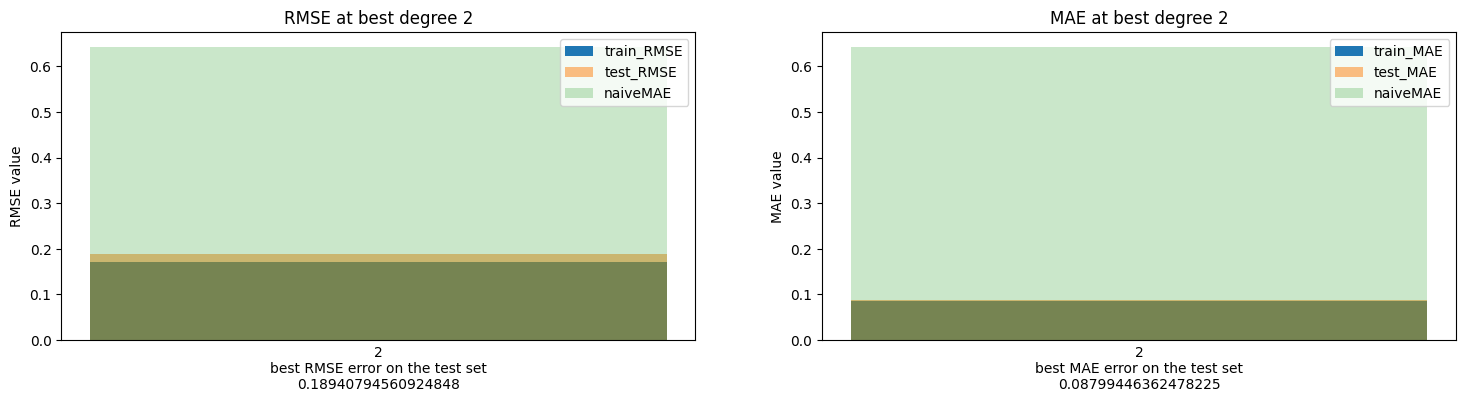

In [ ]:
# https://www.youtube.com/watch?v=G0Olm-4CP50
# build a data frame of the collected errors 
rows = []
for i, deg in enumerate(poly_deg):
    m = train_and_test_errors_at_given_degree[i]
    rows.append({
		'deg' : deg,
		'train_RMSE' : m['train']['RMSE'],
  		'test_RMSE' : m['test']['RMSE'],
    	'train_MAE' : m['train']['MAE'],
		'test_MAE' : m['test']['MAE'],
		'naiveMAE' : m['naive_MAE']

	})
# make a dataframe of the rows list using .sort_values by degree
metrics_df = pd.DataFrame(rows).sort_values(['test_RMSE', 'test_MAE'], ascending=True)

print(metrics_df)
# pick best degree (row) by the lowest test RMSE key then test MAE key then initialize the 
best_row = metrics_df.sort_values(['test_RMSE', 'test_MAE'], ascending=True).iloc[0]  ## used AI to learn about the approach of the tie break (since RMSE punishes )
print(best_row)
best_degree = int(best_row['deg'])
print(best_degree)

# plot bar charts t ocompare errors accross degrees 
fig, axs = plt.subplots(1, 2, figsize=(18, 4))
	# - axs 0, 1, and 2 is the bar of the degree key for x and te train/test_error key for y, make sure to use aplpha to make it more transparent
# axs[0].bar(metrics_df['deg'], metrics_df['train_RMSE'], label='train_RMSE', alpha=1)
# axs[0].bar(metrics_df['deg'], metrics_df['test_RMSE'], label='test_RMSE', alpha=0.5)
# axs[0].set_title('RMSE for each degree')
# axs[0].set_xlabel('degree')
# axs[0].set_ylabel('RMSE')
# axs[0].legend()

# axs[1].bar(metrics_df['deg'], metrics_df['train_MAE'], label='train_MAE', alpha=1)
# axs[1].bar(metrics_df['deg'], metrics_df['test_MAE'], label='test_MAE', alpha=0.5)
# axs[1].set_title('MAE for each degree')
# axs[1].set_xlabel('degree')
# axs[1].set_ylabel('MAE')
# axs[1].legend()

def bar_chart():
	axs[0].bar(best_row['deg'], best_row['train_RMSE'], label='train_RMSE', alpha=1)
	axs[0].bar(best_row['deg'], best_row['test_RMSE'], label='test_RMSE', alpha=0.5)
	axs[0].bar(best_row['deg'], best_row['naiveMAE'], label='naiveMAE', alpha=0.25)
	axs[0].set_title(f'RMSE at best degree {best_degree}')
	axs[0].set_xlabel(f"{best_degree}\nbest RMSE error on the test set\n{best_row['test_RMSE']}")
	axs[0].set_xticks([])
	axs[0].set_ylabel('RMSE value')
	axs[0].legend()

	axs[1].bar(best_row['deg'], best_row['train_MAE'], label='train_MAE', alpha=1)
	axs[1].bar(best_row['deg'], best_row['test_MAE'], label='test_MAE', alpha=0.5)
	axs[1].bar(best_row['deg'], best_row['naiveMAE'], label='naiveMAE', alpha=0.25)
	axs[1].set_title(f'MAE at best degree {best_degree}')
	axs[1].set_xlabel(f"{best_degree}\nbest MAE error on the test set\n{best_row['test_MAE']}")
	axs[1].set_xticks([])
	axs[1].set_ylabel('MAE value')
	axs[1].legend()

	return axs[0], axs[1]

bar_chart1, bar_chart2 = bar_chart()




## I am going to ask a TA about how to get the graph of the best degree here alonside with the prediction value that can be returned to the front end and have that prediction value plotted as a point on the graph

$$\mathbf{v}^\top \hat{\mathbf{u}} =

# FINAL THINGS THAT NEED TO BE PUSHED TO THE FRONT END
## 1) the best fit graph
## 2) the 'RMSE at best degree' and 'MAE at best degree' bar charts
## 3) the predicted value (accompanied by the name of the currency preferably)